In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [20]:
df=pd.read_excel('updated_data.xlsx')
df = df.sample(frac=1)

## Training without kfold 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.comment_text,df.isAbusive, test_size = 0.20)

v = TfidfVectorizer()
X_train_count = v.fit_transform(X_train.values)
# 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
model = SVC(kernel='rbf')
model.fit(X_train_count, y_train)



X_test_count = v.transform(X_test)
score = model.score(X_test_count, y_test)
print("Accuracy = ", score*100)

Accuracy =  86.4481409001957


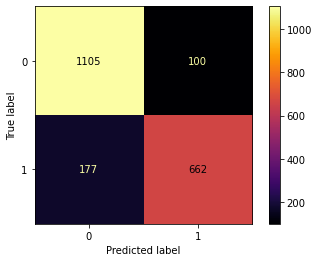

In [25]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test_count, y_test,cmap='inferno')

## Using Kfold

In [26]:
acc_m_svc = 0.0
f1_m_svc = 0.0
pre_m_svc = 0.0
recall_m_svc = 0.0
n = 10
v = TfidfVectorizer()

x = df.comment_text
y = df.isAbusive


kf = KFold(n_splits=n)
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    model = SVC(kernel='rbf')

    X_train_vector = v.fit_transform(X_train.values)
    X_test_vector = v.transform(X_test.values)
    
    model.fit(X_train_vector,y_train)
    
    y_pred = model.predict(X_test_vector)

    acc_m_svc = acc_m_svc + accuracy_score(y_test, y_pred)
    pre_m_svc = pre_m_svc + precision_score(y_test, y_pred,average='weighted')
    f1_m_svc = f1_m_svc + f1_score(y_test, y_pred,average='weighted')
    recall_m_svc = recall_m_svc + recall_score(y_test, y_pred,average='weighted')

print("accuracy  : " , acc_m_svc/n)
print("Precision : " , pre_m_svc/n)
print("F1 Score  : " , f1_m_svc/n)
print("Recall    : " , recall_m_svc/n)

accuracy  :  0.8309887662416072
Precision :  0.9677631849609021
F1 Score  :  0.8899660800054106
Recall    :  0.8309887662416072


In [7]:
acc_m_svc = 0.0
f1_m_svc = 0.0
pre_m_svc = 0.0
recall_m_svc = 0.0
n = 10
v = TfidfVectorizer()

x = df.comment_text
y = df.isAbusive


kf = KFold(n_splits=n)
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    model = SVC(kernel='linear')

    X_train_vector = v.fit_transform(X_train.values)
    X_test_vector = v.transform(X_test.values)
    
    model.fit(X_train_vector,y_train)
    
    y_pred = model.predict(X_test_vector)

    acc_m_svc = acc_m_svc + accuracy_score(y_test, y_pred)
    pre_m_svc = pre_m_svc + precision_score(y_test, y_pred,average='weighted')
    f1_m_svc = f1_m_svc + f1_score(y_test, y_pred,average='weighted')
    recall_m_svc = recall_m_svc + recall_score(y_test, y_pred,average='weighted')

print("accuracy  : " , acc_m_svc/n)
print("Precision : " , pre_m_svc/n)
print("F1 Score  : " , f1_m_svc/n)
print("Recall    : " , recall_m_svc/n)

accuracy  :  0.8114099028043187
Precision :  0.9650384517717112
F1 Score  :  0.8788622879360407
Recall    :  0.8114099028043187


In [32]:
text = [
    'অপেক্ষা করেন, সত্যতা বের হয়ে আসবেই',
    'উনার চোখ চকচক করে উঠলো',
    'বাইঞ্চুদ তুই রেডি থাক, ইফতারের পর বুঝবি ঠেলা কারে কয়',
    'কুত্তার বাচ্চা'
]
text_count = v.transform(text)
model.predict(text_count)

array([0, 0, 1, 1], dtype=int64)